<a href="https://colab.research.google.com/github/rodi612/toy_store/blob/main/Rodrigo_Cinema_Paradiso_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STEP 1: Install required packages
!pip install google-cloud-bigquery pandas matplotlib seaborn plotly

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from google.cloud import bigquery
from google.colab import auth
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Authenticate with Google Cloud
print("🔐 Authenticating with Google Cloud...")
auth.authenticate_user()
print("✅ Authentication successful!")

#

🔐 Authenticating with Google Cloud...
✅ Authentication successful!
🔗 Connected to BigQuery project: cinemaparadiso-462409
❌ Connection error: 404 Not found: Table cinemaparadiso-462409:cinema_paradiso.fa_movie_stats_profitability_metrics was not found in location EU; reason: notFound, message: Not found: Table cinemaparadiso-462409:cinema_paradiso.fa_movie_stats_profitability_metrics was not found in location EU

Location: EU
Job ID: df007463-5e68-471c-b64f-f374c23bae8d



In [15]:
# STEP 4: Set up BigQuery client
project_id = 'cinemaparadiso-462409'
client = bigquery.Client(project=project_id)
print(f"🔗 Connected to BigQuery project: {project_id}")

# STEP 5: Test connection with correct table name
test_query = """
SELECT COUNT(*) as total_rows
FROM `cinemaparadiso-462409.cinema_paradiso.fa_movie_stats_prof_metrics`
"""

try:
    result = client.query(test_query).to_dataframe()
    print(f"🎬 Data connection successful! Found {result['total_rows'].iloc[0]} movies in your dataset")
except Exception as e:
    print(f"❌ Connection error: {e}")


🔗 Connected to BigQuery project: cinemaparadiso-462409
🎬 Data connection successful! Found 4054 movies in your dataset


In [16]:
# ========================================
# CINEMA PARADISO - KEY PERFORMANCE INDICATORS
# ========================================

print("🎬 CINEMA PARADISO - PROFITABILITY ANALYSIS")
print("=" * 60)

# Load your data with correct table name
movie_query = """
SELECT
    title_title,
    year,
    production_budget,
    domestic_gross,
    worldwide_gross,
    domestic_profit,
    worldwide_profit,
    domestic_roi,
    worldwide_roi,
    profitability_category,
    rating,
    votes,
    quality_efficiency_score,
    domestic_percentage,
    votes_per_million_budget
FROM `cinemaparadiso-462409.cinema_paradiso.fa_movie_stats_prof_metrics`
WHERE production_budget > 0 AND worldwide_gross > 0
ORDER BY worldwide_roi DESC
"""

movies_df = client.query(movie_query).to_dataframe()
print(f"✅ Loaded {len(movies_df)} movies for analysis\n")

# ========================================
# KPI 1: OVERALL PROFITABILITY SCORECARD
# ========================================

total_films = len(movies_df)
profitable_films = (movies_df['worldwide_roi'] >= 2.0).sum()
highly_profitable = (movies_df['worldwide_roi'] >= 3.0).sum()
avg_roi = movies_df['worldwide_roi'].mean()
avg_rating = movies_df['rating'].mean()

print("📈 PROFITABILITY SCORECARD")
print("-" * 40)
print(f"Total Films Analyzed: {total_films:,}")
print(f"Profitable Films (ROI ≥ 2x): {profitable_films:,} ({profitable_films/total_films*100:.1f}%)")
print(f"Highly Profitable (ROI ≥ 3x): {highly_profitable:,} ({highly_profitable/total_films*100:.1f}%)")
print(f"Average ROI: {avg_roi:.1f}x")
print(f"Average Rating: {avg_rating:.1f}/10")

🎬 CINEMA PARADISO - PROFITABILITY ANALYSIS
✅ Loaded 4054 movies for analysis

📈 PROFITABILITY SCORECARD
----------------------------------------
Total Films Analyzed: 4,054
Profitable Films (ROI ≥ 2x): 2,058 (50.8%)
Highly Profitable (ROI ≥ 3x): 1,448 (35.7%)
Average ROI: 4.5x
Average Rating: 6.4/10


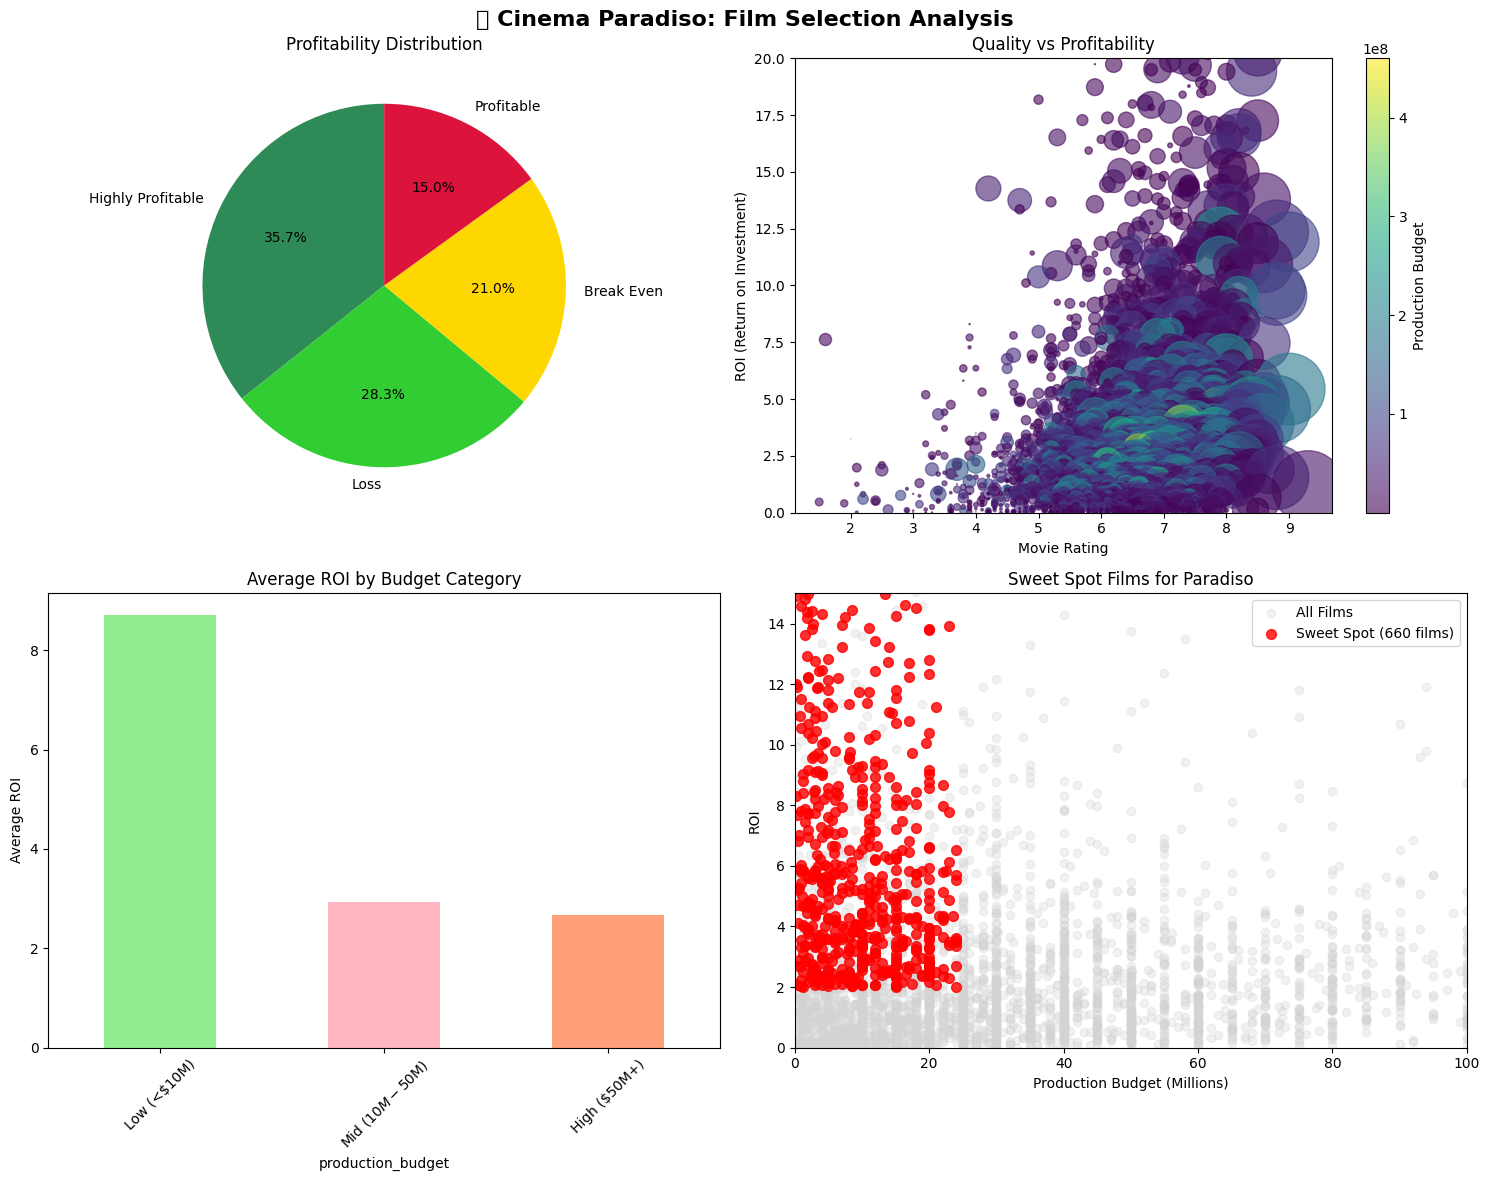


🎯 SWEET SPOT ANALYSIS:
Found 660 films perfect for Cinema Paradiso!
Average ROI: 13.2x
Average Rating: 7.3/10
Average Budget: $9.2M


In [17]:
# ========================================
# VISUALIZATION 1: PROFITABILITY DISTRIBUTION
# ========================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🎬 Cinema Paradiso: Film Selection Analysis', fontsize=16, fontweight='bold')

# Chart 1: Profitability Category Distribution
profitability_counts = movies_df['profitability_category'].value_counts()
colors = ['#2E8B57', '#32CD32', '#FFD700', '#DC143C']  # Green to Red
ax1.pie(profitability_counts.values, labels=profitability_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Profitability Distribution')

# Chart 2: ROI vs Rating Scatter Plot
scatter = ax2.scatter(movies_df['rating'], movies_df['worldwide_roi'],
                     c=movies_df['production_budget'], s=movies_df['votes']/1000,
                     alpha=0.6, cmap='viridis')
ax2.set_xlabel('Movie Rating')
ax2.set_ylabel('ROI (Return on Investment)')
ax2.set_title('Quality vs Profitability')
ax2.set_ylim(0, 20)  # Limit y-axis for better visibility
plt.colorbar(scatter, ax=ax2, label='Production Budget')

# Chart 3: Budget Categories Performance
budget_categories = pd.cut(movies_df['production_budget'],
                          bins=[0, 10_000_000, 50_000_000, float('inf')],
                          labels=['Low (<$10M)', 'Mid ($10M-$50M)', 'High ($50M+)'])
budget_roi = movies_df.groupby(budget_categories)['worldwide_roi'].mean()
budget_roi.plot(kind='bar', ax=ax3, color=['#90EE90', '#FFB6C1', '#FFA07A'])
ax3.set_title('Average ROI by Budget Category')
ax3.set_ylabel('Average ROI')
ax3.tick_params(axis='x', rotation=45)

# Chart 4: Sweet Spot Films Identification
sweet_spot = movies_df[
    (movies_df['production_budget'] < 25_000_000) &
    (movies_df['worldwide_roi'] >= 2.0) &
    (movies_df['rating'] >= 6.5) &
    (movies_df['votes'] >= 5000)
]

ax4.scatter(movies_df['production_budget']/1_000_000, movies_df['worldwide_roi'],
           alpha=0.3, label='All Films', color='lightgray')
ax4.scatter(sweet_spot['production_budget']/1_000_000, sweet_spot['worldwide_roi'],
           alpha=0.8, label=f'Sweet Spot ({len(sweet_spot)} films)', color='red', s=50)
ax4.set_xlabel('Production Budget (Millions)')
ax4.set_ylabel('ROI')
ax4.set_title('Sweet Spot Films for Paradiso')
ax4.legend()
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 15)

plt.tight_layout()
plt.show()

print(f"\n🎯 SWEET SPOT ANALYSIS:")
print(f"Found {len(sweet_spot)} films perfect for Cinema Paradiso!")
print(f"Average ROI: {sweet_spot['worldwide_roi'].mean():.1f}x")
print(f"Average Rating: {sweet_spot['rating'].mean():.1f}/10")
print(f"Average Budget: ${sweet_spot['production_budget'].mean()/1_000_000:.1f}M")

In [18]:
# ========================================
# KPI 2: TOP PERFORMING FILMS FOR PARADISO
# ========================================

print("\n🏆 TOP 10 RECOMMENDED FILMS FOR CINEMA PARADISO")
print("=" * 70)

# Filter for sweet spot films and rank by efficiency
paradiso_films = movies_df[
    (movies_df['production_budget'] < 30_000_000) &  # Affordable
    (movies_df['worldwide_roi'] >= 2.0) &           # Profitable
    (movies_df['rating'] >= 6.5) &                  # Quality
    (movies_df['votes'] >= 3000)                    # Audience interest
].sort_values('quality_efficiency_score', ascending=False).head(10)

for i, (_, film) in enumerate(paradiso_films.iterrows(), 1):
    print(f"{i:2d}. {film['title_title'][:40]:40} | "
          f"ROI: {film['worldwide_roi']:5.1f}x | "
          f"Rating: {film['rating']:.1f}/10 | "
          f"Budget: ${film['production_budget']/1_000_000:4.1f}M")

# ========================================
# KPI 3: BUDGET TIER ANALYSIS
# ========================================

print(f"\n💰 BUDGET TIER PERFORMANCE ANALYSIS")
print("=" * 50)

budget_analysis = movies_df.groupby(
    pd.cut(movies_df['production_budget'],
           bins=[0, 10_000_000, 50_000_000, float('inf')],
           labels=['Low Budget (<$10M)', 'Mid Budget ($10M-$50M)', 'High Budget ($50M+)'])
).agg({
    'worldwide_roi': 'mean',
    'rating': 'mean',
    'title_title': 'count',
    'quality_efficiency_score': 'mean'
}).round(2)

budget_analysis.columns = ['Avg ROI', 'Avg Rating', 'Film Count', 'Quality Efficiency']
print(budget_analysis)

# ========================================
# KPI 4: PROFITABILITY TRENDS BY YEAR
# ========================================

print(f"\n📅 RECENT PROFITABILITY TRENDS (2020-2024)")
print("=" * 45)

recent_trends = movies_df[movies_df['year'] >= 2020].groupby('year').agg({
    'worldwide_roi': 'mean',
    'rating': 'mean',
    'title_title': 'count'
}).round(2)

recent_trends.columns = ['Avg ROI', 'Avg Rating', 'Films Released']
print(recent_trends)


🏆 TOP 10 RECOMMENDED FILMS FOR CINEMA PARADISO
 1. pi                                       | ROI:  68.8x | Rating: 7.3/10 | Budget: $ 0.1M
 2. super size me                            | ROI: 342.1x | Rating: 7.2/10 | Budget: $ 0.1M
 3. night of the living dead                 | ROI: 263.9x | Rating: 7.8/10 | Budget: $ 0.1M
 4. eraserhead                               | ROI:  71.0x | Rating: 7.3/10 | Budget: $ 0.1M
 5. mad max                                  | ROI: 498.8x | Rating: 6.8/10 | Budget: $ 0.2M
 6. reservoir dogs                           | ROI:   2.5x | Rating: 8.3/10 | Budget: $ 1.2M
 7. halloween                                | ROI: 216.2x | Rating: 7.7/10 | Budget: $ 0.3M
 8. once                                     | ROI: 154.3x | Rating: 7.8/10 | Budget: $ 0.1M
 9. a ghost story                            | ROI:  27.7x | Rating: 6.8/10 | Budget: $ 0.1M
10. rocky                                    | ROI: 225.0x | Rating: 8.1/10 | Budget: $ 1.0M

💰 BUDGET TIER PERFORM

In [19]:
# ========================================
# 🎯 STRATEGIC RECOMMENDATIONS FOR CINEMA PARADISO
# ========================================

print("\n" + "="*60)
print("🎯 STRATEGIC RECOMMENDATIONS FOR CINEMA PARADISO")
print("="*60)

# Calculate key metrics
low_budget_high_roi = movies_df[
    (movies_df['production_budget'] < 15_000_000) &
    (movies_df['worldwide_roi'] >= 3.0)
]

quality_films = movies_df[movies_df['rating'] >= 7.0]
affordable_quality = quality_films[quality_films['production_budget'] < 25_000_000]

print(f"📊 KEY INSIGHTS:")
print(f"   • {len(low_budget_high_roi)} low-budget films with 3x+ ROI available")
print(f"   • {len(affordable_quality)} high-quality films under $25M budget")
print(f"   • Best budget range: $5M-$25M (avg ROI: {movies_df[(movies_df['production_budget'] >= 5_000_000) & (movies_df['production_budget'] <= 25_000_000)]['worldwide_roi'].mean():.1f}x)")

print(f"\n💡 PROGRAMMING STRATEGY:")
print(f"   • Target films with 2-10x ROI (avoid mega-hits with expensive licensing)")
print(f"   • Focus on 7.0+ rated films under $25M budget")
print(f"   • Sweet spot: {len(sweet_spot)} films identified for acquisition")

print(f"\n🎬 IMMEDIATE ACTIONS:")
print(f"   • Review top 10 recommended films above")
print(f"   • Negotiate licensing for low-budget, high-ROI films")
print(f"   • Avoid films over $50M budget (licensing too expensive)")

print(f"\n✅ SUCCESS METRICS TO TRACK:")
print(f"   • Target ROI: 2.5x minimum")
print(f"   • Quality threshold: 6.5+ rating")
print(f"   • Budget limit: <$25M for affordable licensing")


🎯 STRATEGIC RECOMMENDATIONS FOR CINEMA PARADISO
📊 KEY INSIGHTS:
   • 628 low-budget films with 3x+ ROI available
   • 703 high-quality films under $25M budget
   • Best budget range: $5M-$25M (avg ROI: 3.7x)

💡 PROGRAMMING STRATEGY:
   • Target films with 2-10x ROI (avoid mega-hits with expensive licensing)
   • Focus on 7.0+ rated films under $25M budget
   • Sweet spot: 660 films identified for acquisition

🎬 IMMEDIATE ACTIONS:
   • Review top 10 recommended films above
   • Negotiate licensing for low-budget, high-ROI films
   • Avoid films over $50M budget (licensing too expensive)

✅ SUCCESS METRICS TO TRACK:
   • Target ROI: 2.5x minimum
   • Quality threshold: 6.5+ rating
   • Budget limit: <$25M for affordable licensing


In [ ]:
## TAble
SELECT * FROM `cinemaparadiso-462409.cinema_paradiso.cinema_hall_ticket_sales` LIMIT 5